In [24]:
import keras
import random
import time
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import deque
from tic_tac_toe import *
from keras import layers, models, activations, optimizers, losses

In [25]:
class DQN:
    def __init__(
        self, discount_factor: float, folder: str, replay_memory_length=50000
    ) -> None:
        self.y = discount_factor
        self.folder = folder
        self.q_network = self._create_model()
        self.target_network = self._create_model()
        try:
            self.q_network.load_weights(os.path.join(self.folder, "weights.keras"))
            print("Loaded weights")
        except Exception as e:
            print(f"Can't load weights: {e}")
        finally:
            self.update_target_model()
        try:
            with open(os.path.join(self.folder, "replay_memory.pkl"), "rb") as file:
                self.replay_memory = pickle.load(file)
            print("Loaded replay memory")
        except Exception as e:
            self.replay_memory = deque(maxlen=replay_memory_length)
            print(f"Couldn't load replay memory: {e}")

    def _create_model(self):
        model = models.Sequential(
            [
                layers.InputLayer(input_shape=(9, 3)),
                layers.Flatten(),
                layers.Dense(128, activation="relu"),
                layers.Dense(128, activation="relu"),
                layers.Dense(9, activation="linear"),
            ]
        )
        model.compile(optimizer=optimizers.Adam(), loss="mse")
        return model

    def _create_batch(self, batch_size=128, to_zip=True):
        batch = random.sample(self.replay_memory, batch_size)
        if to_zip:
            states, actions, rewards, next_states, terminals = zip(*batch)

            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            next_states = np.array(next_states)
            terminals = np.array(terminals)

            return states, actions, rewards, next_states, terminals
        return batch

    def _format_state(self, state):
        return tf.one_hot(state, 3)

    def update_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def predict_action(self, obs, epsilon=0):
        if random.random() > epsilon:  # exploit
            state = self._format_state(obs)
            x = np.expand_dims(state, 0)
            q_values = self.q_network(x)[0]
            return best_action(q_values, obs)
        # explore
        return random_action(obs)

    def add_data(self, state, action, reward, next_state, terminal):
        self.replay_memory.append(
            (
                self._format_state(state),
                action,
                reward,
                self._format_state(next_state),
                int(terminal),
            )
        )

    def save_data(self):
        self.q_network.save_weights(os.path.join(self.folder, "weights.keras"))
        with open(os.path.join(self.folder, "replay_memory.pkl"), "wb") as file:
            pickle.dump(self.replay_memory, file)

    def learn(self, batch_size):
        start = time.time()
        """losses = []
        for state, action, reward, next_state, terminal in self._create_batch(
            batch_size, False
        ):
            expanded_state = np.expand_dims(state, 0)
            expanded_next_state = np.expand_dims(next_state, 0)
            target_pred = np.max(self.target_network(expanded_next_state))
            target_value = reward + self.y * target_pred * (1 - terminal)

            q_values = np.array(self.q_network(expanded_state)[0])
            q_values[action] = target_value

            loss = self.q_network.train_on_batch(
                expanded_state, np.expand_dims(q_values, 0)
            )
            # loss = history.history["loss"][0]
            losses.append(loss)

        # print(time.time() - start)
        return np.average(losses)"""
        states, actions, rewards, next_states, terminals = self._create_batch(
            batch_size
        )

        target_preds = self._max_q_values(
            self.target_network.predict(next_states, verbose=0), next_states
        )
        target_values = rewards + self.y * target_preds * (1 - terminals)

        q_values = self.q_network.predict(states, verbose=0)
        q_values[np.arange(len(q_values)), actions] = target_values

        loss = self.q_network.train_on_batch(states, q_values)
        # loss = history.history["loss"][0]
        # print(time.time() - start)
        return loss

    def _max_q_values(self, target_preds, next_states):
        max_preds = []
        for i, q_values in enumerate(target_preds):
            best_action_index = 0
            while next_states[i][best_action_index][0] != 0:
                best_action_index += 1
            for j in range(best_action_index + 1, len(next_states[i])):
                if next_states[i][j][0] == 0 and q_values[j] > q_values[best_action_index]:
                    best_action_index = j
            max_preds.append(q_values[best_action_index])
        return np.array(max_preds)

In [26]:
def time_until_done(start_time, episode, num_episodes):
    current_time = time.time()
    elapsed_time = current_time - start_time

    average_time_per_episode = elapsed_time / episode
    remaining_episodes = num_episodes - episode
    estimated_remaining_time = remaining_episodes * average_time_per_episode

    # Calculate days, hours, minutes, and seconds
    days, remainder = divmod(estimated_remaining_time, 86400)
    hours, remainder = divmod(remainder, 3600)
    minutes, seconds = divmod(remainder, 60)

    return f"{int(days)} days, {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds"

In [27]:
num_episodes = 5000
target_update_frequency = 1000
train_after_actions = 5
a = 0.1  # learning rate
y = 0.99  # discount factor
initial_epsilon = 1.0
final_epsilon = 0.1
batch_size = 32
win_reward = 10
lose_reward = -10
tie_reward = 1

epsilon_decay_rate = (initial_epsilon - final_epsilon) / num_episodes
epsilon = initial_epsilon
win_rate_check = max(num_episodes // 100, 1)

env = TicTacToeEnv(
    render=False,
    human_env=False,
    auto_block=True,
    auto_win=True,
    win_reward=win_reward,
    lose_reward=lose_reward,
    tie_reward=tie_reward,
)
win_rate_history = ([], [])
tie_rate_history = ([], [])
lose_rate_history = ([], [])
loss_history = ([], [])

Can't load weights: [Errno 2] Unable to synchronously open file (unable to open file: name = '.\tic_tac_toe_agent\weights.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Couldn't load replay memory: [Errno 2] No such file or directory: '.\\tic_tac_toe_agent\\replay_memory.pkl'


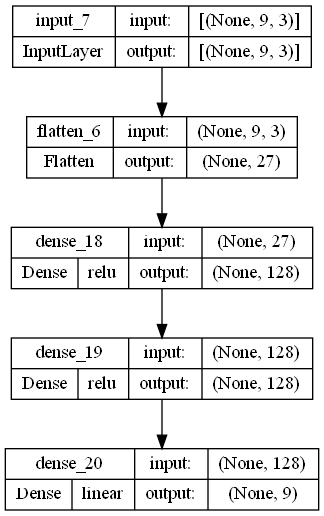

In [28]:
agent = DQN(y, r".\tic_tac_toe_agent")
keras.utils.plot_model(agent.q_network, show_shapes=True, show_layer_activations=True)

In [29]:
games_won = 0
games_tied = 0
games_lost = 0
steps = 0
loss_sum = 0
start_time = time.time()
epsilon = epsilon  # vs code thinks that it is unbound if I remove this line

for episode in range(1, num_episodes + 1):
    obs = env.reset(
        env_starts=random.choice([True, False]),
    )
    while True:
        action = win_action(obs, 2)
        if action == -1:
            action = block_action(obs, 2)
            if action == -1:
                action = agent.predict_action(obs, epsilon)
        next_obs, reward, done = env.step(action)

        agent.add_data(obs, action, reward, next_obs, done)
        if len(agent.replay_memory) >= batch_size and steps % train_after_actions == 0:
            loss = agent.learn(batch_size)
            loss_sum += loss

        obs = next_obs
        steps += 1
        if steps % target_update_frequency == 0:
            agent.update_target_model()
        if done:
            if reward == win_reward:
                games_won += 1
            elif reward == tie_reward:
                games_tied += 1
            elif reward == lose_reward:
                games_lost += 1
            break

    # Update epsilon for the next episode
    epsilon -= epsilon_decay_rate
    epsilon = max(
        final_epsilon, epsilon
    )  # Ensure epsilon doesn't go below the final value
    if episode % win_rate_check == 0:
        win_rate = games_won / win_rate_check * 100
        tie_rate = games_tied / win_rate_check * 100
        lose_rate = games_lost / win_rate_check * 100
        average_loss = loss_sum / win_rate_check
        print(
            f"Episods done: {episode}, win rate: {win_rate:.1f}%, average loss: {average_loss},"
            + f" estimated time until completion: {time_until_done(start_time, episode, num_episodes)}"
        )
        win_rate_history[0].append(episode)
        win_rate_history[1].append(win_rate)
        tie_rate_history[0].append(episode)
        tie_rate_history[1].append(tie_rate)
        lose_rate_history[0].append(episode)
        lose_rate_history[1].append(lose_rate)
        loss_history[0].append(episode)
        loss_history[1].append(average_loss)
        games_won = 0
        games_tied = 0
        games_lost = 0
        loss_sum = 0

env.close()

Episods done: 50, win rate: 20.0%, average loss: 0.7712810748815536, estimated time until completion: 0 days, 0 hours, 9 minutes, 50 seconds
Episods done: 100, win rate: 24.0%, average loss: 0.6248046038299799, estimated time until completion: 0 days, 0 hours, 9 minutes, 35 seconds
Episods done: 150, win rate: 28.0%, average loss: 0.5967877519130707, estimated time until completion: 0 days, 0 hours, 9 minutes, 22 seconds
Episods done: 200, win rate: 34.0%, average loss: 0.5986257357895375, estimated time until completion: 0 days, 0 hours, 9 minutes, 20 seconds
Episods done: 250, win rate: 32.0%, average loss: 0.6551780194044113, estimated time until completion: 0 days, 0 hours, 10 minutes, 9 seconds
Episods done: 300, win rate: 30.0%, average loss: 0.6633647409081459, estimated time until completion: 0 days, 0 hours, 10 minutes, 1 seconds
Episods done: 350, win rate: 24.0%, average loss: 0.7713681691884995, estimated time until completion: 0 days, 0 hours, 10 minutes, 1 seconds
Episods

In [30]:
print(len(agent.replay_memory))

21250


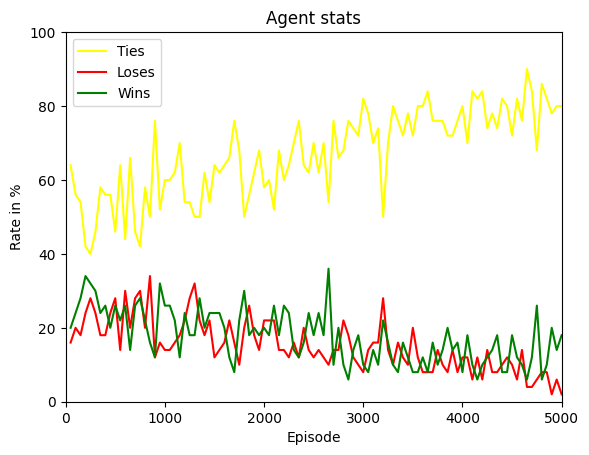

In [31]:
# Win rates
if win_rate_history[0]:
    plt.plot(tie_rate_history[0], tie_rate_history[1], label="Ties", color="yellow")
    plt.plot(lose_rate_history[0], lose_rate_history[1], label="Loses", color="red")
    plt.plot(win_rate_history[0], win_rate_history[1], label="Wins", color="green")
    plt.title("Agent stats")
    plt.ylabel("Rate in %")
    plt.xlabel("Episode")
    plt.ylim(bottom=0, top=100)
    plt.xlim(left=0, right=num_episodes)
    plt.legend()
    plt.show()

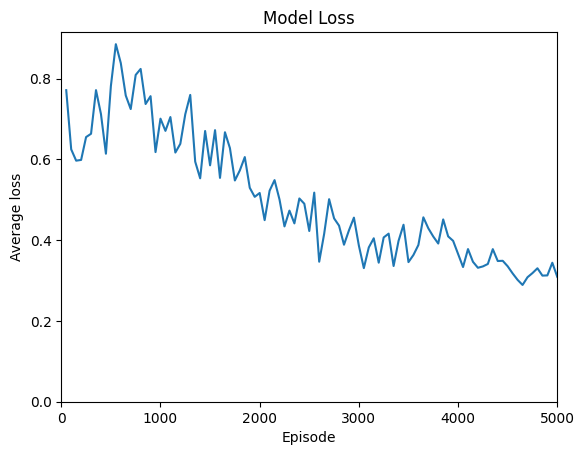

In [32]:
# Loss
if loss_history[0]:
    plt.plot(loss_history[0], loss_history[1])
    plt.title("Model Loss")
    plt.ylabel("Average loss")
    plt.xlabel("Episode")
    plt.ylim(bottom=0)
    plt.xlim(left=0, right=num_episodes)
    plt.show()

In [33]:
env = TicTacToeEnv(render=True, fps=60, human_env=True)
closed = False

while not closed:
    try:
        obs = env.reset(env_starts=random.choice([True, False]))
    except KeyboardInterrupt:  # The game was closed
        break
    while True:
        action = win_action(obs, 2)
        if action == -1:
            action = block_action(obs, 2)
            if action == -1:
                action = agent.predict_action(obs)
        try:
            obs, reward, done = env.step(action)
        except KeyboardInterrupt:
            closed = True
            break
        if done:
            for _ in range(150):
                env.clock.tick(60)
            break

In [34]:
agent.save_data()